# Inversion of photoelastic fringes

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 15 16:03:43 2018

@author: Simon GM
"""

%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import imageio
from tkinter import *
from tkinter import filedialog
plt.style.use('ggplot') 

Definition of constants

In [3]:
# fringe value [N/m]
fs=4000.0 
# plate thickness [m]
h=0.01 # 
# dilational wave speed [m/s]
cd=1860.0
# shear wave speed [m/s]
cs=893.0
# crack speed [m/s]
v=0.92*cs
print('rupture front velocity: '+ str(v) + 'm/s')

rupture front velocity: 821.5600000000001m/s


# Equations used

Equations for a propagating crack Freund's book, 1990.
They are written in the form:

$\sigma_{ij} = \frac{K_I(t)}{\sqrt{2 \pi r}} \Sigma^I_{ij} + \frac{K_{II}(t)}{\sqrt{2 \pi r}} \Sigma^{II}_{ij}$

(except $\sigma_{11} = \frac{K_I(t)}{\sqrt{2 \pi r}} \Sigma^I_{11} + \frac{K_{II}(t)}{\sqrt{2 \pi r}} \Sigma^{II}_{11} + \sigma_{0x}$ where $\sigma_{0x} = \sigma_{22}^{\infty}-\sigma_{11}^{\infty}$ which represents the difference of remote stresses (Dally p 509))

Freund p163 gives equations for a mode I dynamic crack:

$\Sigma^I_{11} = \frac{1}{D}[(1 + \alpha_s^2)(1+2 \alpha_d^2 - \alpha_s^2)\frac{cos(\theta_d/2)}{\sqrt{\gamma_d}}  - 4 \alpha_s \alpha_d \frac{cos(\theta_s/2)}{\sqrt{\gamma_s}}]$

$\Sigma^I_{12} = \frac{2 \alpha_d (1 + \alpha_s^2)}{D}[\frac{sin(\theta_d/2)}{\sqrt{\gamma_d}} -  \frac{sin(\theta_s/2)}{\sqrt{\gamma_s}}]$

$\Sigma^I_{22} = - \frac{1}{D}[(1 + \alpha_s^2)^2 \frac{cos(\theta_d/2)}{\sqrt{\gamma_d}} - 4 \alpha_s \alpha_d \frac{cos(\theta_s/2)}{\sqrt{\gamma_s}}]$

Freund  p171 gives equations for a mode II dynamic crack:

$\Sigma^{II}_{11} = - \frac{2 \alpha_s}{D}[(1+2 \alpha_d^2 - \alpha_s^2)\frac{sin(\theta_d/2)}{\sqrt{\gamma_d}} - (1 + \alpha_s^2) \frac{sin(\theta_s/2)}{\sqrt{\gamma_s}}]$

$\Sigma^{II}_{12} = \frac{1}{D}[4 \alpha_s \alpha_d \frac{cos(\theta_d/2)}{\sqrt{\gamma_d}} -  (1 + \alpha_s^2)^2 \frac{sin(\theta_s/2)}{\sqrt{\gamma_s}}]$

$\Sigma^{II}_{22} = \frac{2 \alpha_s (1 + \alpha_s^2)}{D}[\frac{sin(\theta_d/2)}{\sqrt{\gamma_d}} -  \frac{sin(\theta_s/2)}{\sqrt{\gamma_s}}]$

Where

$D= 4 \alpha_s \alpha_d -(1+\alpha_s^2)^2$

$\gamma_d = \sqrt{1-(\frac{v sin \theta}{c_d})^2}$

$\gamma_s = \sqrt{1-(\frac{v sin \theta}{c_s})^2}$

angles and radius for polar coordinates ($\theta$, $r$), also taking into account the lorentz contractions for rupture approaching P-wave ($\theta_d$, $r_d$) speed and S-wave speed ($\theta_s$, $r_s$)

$ \theta_s = tan^{-1}(y. \alpha_s/x) $ 

$ \theta_d = tan^{-1}(y. \alpha_d/x) $ 

$ \theta = tan^{-1}(y/x) $ 

$ r_s = \sqrt{x^2 + (y \alpha_s)^2}$

$ r_d = \sqrt{x^2 + (y \alpha_d)^2}$

$ r = \sqrt{x^2 + y^2}$

Lorentz contractions for the P (cd) and S wave speeds (cs):

$ \alpha_d = \sqrt{1-(\frac{v}{cd})^2}$ 

$ \alpha_s = \sqrt{1-(\frac{v}{cs})^2}$

(if the crack speed $v$ is negligeable, $\alpha_d \approx \alpha_s \approx 1$)



-> From the 3 stresses we can compute the maximum shear stress $\tau_{max}$ which will give the theoretical fringe number $N$ of the isochromatics.

Using the equations of Dally p17 & p19:

$\tau_{max} = \frac{1}{2} (\sigma_{max}-\sigma_{min}) = \frac{1}{2} (\sigma_{1}-\sigma_{2})$ in 2D,

where 

$\sigma_1, \sigma_2 = \frac{\sigma_{11} + \sigma_{22}}{2} \pm \sqrt{(\frac{\sigma_{11} - \sigma_{22}}{2})^2 + \sigma_{12}^2} $

giving

$\tau_{max} = \sqrt{(\frac{\sigma_{11} - \sigma_{22}}{2})^2 + \sigma_{12}^2} $


The fringe number $N$ is given by:

$N =\frac{ 2 \tau_{max} h}{f_{\sigma}}$

We can also plot the theoretical light intensity (isochromatics) if we neglect the so-called isoclinics (light extinction due to the orientation of the principal stresses)

$I = A sin^2(2 \alpha)sin^2(\Delta / 2) + C(x,y)$

where $A$ is the amplitude of the light intensity, $C(x,y)$ is the background light, $sin^2(2 \alpha)$ is the light extinction due to the principal stresses orientation (isoclinics), $\Delta = 2 \pi N $ is called the relative retardation.

In [4]:
def alpha_d(v,cd):
    output=np.sqrt(1-(v/cd)**2)
    return output

def alpha_s(v,cs):
    output=np.sqrt(1-(v/cs)**2)
    return output


print("alpha_d = ", alpha_d(v,cd))
print("alpha_s = ", alpha_s(v,cs))

def teta_s(X,Y,v,cs):
    output=np.arctan2(Y*alpha_s(v,cs),X)
    return output

def teta_d(X,Y,v,cd):
    output=np.arctan2(Y*alpha_d(v,cd),X)
    return output

def teta(X,Y):
    output=np.arctan2(Y,X)
    return output

def r(X,Y):
    output=np.sqrt(Y**2 + X**2)
    return output

def r_s(X,Y,v,cs):
    output=np.sqrt((Y*alpha_s(v,cs))**2 + X**2)
    return output

def r_d(X,Y,v,cd):
    output=np.sqrt((Y*alpha_d(v,cd))**2 + X**2)
    return output

#%% Freund 1990 p163 -171

def gamma_d(v,cd,X,Y):
    output=np.sqrt(1-(v*np.sin(teta(X,Y))/cd)**2)
    return output

def gamma_s(v,cs,X,Y):
    output=np.sqrt(1-(v*np.sin(teta(X,Y))/cs)**2)
    return output

def D(v,cd,cs):
    output= 4 * alpha_d(v,cd) * alpha_s(v,cs) - (1 + alpha_s(v,cs)**2)**2
    return output

## stress functions for mode I
def SS11_I(X,Y,v,cs,cd):
    output = 1/D(v,cd,cs) * ((1+alpha_s(v,cs)**2)*(1+2*alpha_d(v,cd)**2-alpha_s(v,cs)**2) * \
                             np.cos(teta_d(X,Y,v,cd)/2)/np.sqrt(gamma_d(v,cd,X,Y)) - \
                            4 * alpha_d(v,cd) * alpha_s(v,cs) * np.cos(teta_s(X,Y,v,cs)/2)/ \
                             np.sqrt(gamma_s(v,cs,X,Y)))
    return output

def SS22_I(X,Y,v,cs,cd):
    output = -1/D(v,cd,cs) * ((1+alpha_s(v,cs)**2)**2 * np.cos(teta_d(X,Y,v,cd)/2) \
                              /np.sqrt(gamma_d(v,cd,X,Y)) - \
                            4 * alpha_d(v,cd) * alpha_s(v,cs) * np.cos(teta_s(X,Y,v,cs)/2) \
                              /np.sqrt(gamma_s(v,cs,X,Y)))
    return output

def SS12_I(X,Y,v,cs,cd):
    output = 2/D(v,cd,cs) * alpha_d(v,cd) *(1+alpha_s(v,cs)**2) * (np.sin(teta_d(X,Y,v,cd)/2)/ \
                                                                   np.sqrt(gamma_d(v,cd,X,Y)) - \
                            np.sin(teta_s(X,Y,v,cs)/2)/np.sqrt(gamma_s(v,cs,X,Y)))
    return output

#%% stress functions for mode II
def SS11_II(X,Y,v,cs,cd):
    output=-2*alpha_s(v,cs) / D(v,cd,cs) * ((1+2*alpha_d(v,cd)**2-alpha_s(v,cs)**2) * \
                                            np.sin(teta_d(X,Y,v,cd)/2)/np.sqrt(gamma_d(v,cd,X,Y)) - \
           (1+alpha_s(v,cs)**2) * np.sin(teta_s(X,Y,v,cs)/2)/np.sqrt(gamma_s(v,cs,X,Y)))
    return output

def SS12_II(X,Y,v,cs,cd):
    output=1 / D(v,cd,cs) * ( 4 * alpha_d(v,cd) * alpha_s(v,cs) * np.cos(teta_d(X,Y,v,cd)/2)/ \
                             np.sqrt(gamma_d(v,cd,X,Y)) - \
           (1+alpha_s(v,cs)**2)**2 * np.cos(teta_s(X,Y,v,cs)/2)/np.sqrt(gamma_s(v,cs,X,Y)))
    return output

def SS22_II(X,Y,v,cs,cd):
    output=2*alpha_s(v,cs) * (1+alpha_s(v,cs)**2) / D(v,cd,cs) * \
    (np.sin(teta_d(X,Y,v,cd)/2)/np.sqrt(gamma_d(v,cd,X,Y)) - \
      np.sin(teta_s(X,Y,v,cs)/2)/np.sqrt(gamma_s(v,cs,X,Y)))
    return output

## theoretical 2D stress field from KI and KII
def SS11_mixed(X,Y,v,cs,cd,KI,KII,Sox):
    output =1 / np.sqrt(2 * np.pi * r(X,Y)) * \
    (KI * SS11_I(X,Y,v,cs,cd) + KII * SS11_II(X,Y,v,cs,cd)) - Sox
    return output

def SS22_mixed(X,Y,v,cs,cd,KI,KII):
    output =1 / np.sqrt(2 * np.pi * r(X,Y)) * \
    (KI * SS22_I(X,Y,v,cs,cd) + KII * SS22_II(X,Y,v,cs,cd))
    return output

def SS12_mixed(X,Y,v,cs,cd,KI,KII):
    output =1 / np.sqrt(2 * np.pi * r(X,Y)) * \
    (KI * SS12_I(X,Y,v,cs,cd) + KII * SS12_II(X,Y,v,cs,cd))
    return output

def Tmax_mixed(X,Y,v,cs,cd,KI,KII,Sox):
    output = np.sqrt(((SS11_mixed(X,Y,v,cs,cd,KI,KII,Sox)- \
                       SS22_mixed(X,Y,v,cs,cd,KI,KII))/2)**2 + \
                     SS12_mixed(X,Y,v,cs,cd,KI,KII)**2 )
    return output

## Fringe number
def N_frg(X,Y,v,cs,cd,KI,KII,Sox,h,fs):
    output = Tmax_mixed(X,Y,v,cs,cd,KI,KII,Sox) * 2 * h / fs  
    #( if we multiply by * np.sqrt(2) it fits kamulu & kobayashi)
    return output

alpha_d =  0.897163340697
alpha_s =  0.391918358845


<IPython.core.display.Javascript object>


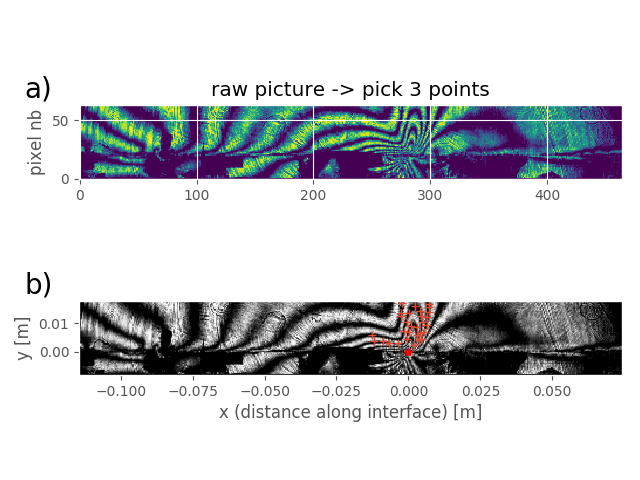

In [15]:
# root = Tk()
# root.withdraw()
# root.update()
# file_path = filedialog.askopenfilename()
# root.destroy()

file_path='013.png'
im = imageio.imread(file_path)
#im=np.array(im)[:,:,0]
f1=plt.figure(1)
ax11=f1.add_subplot(211)
ax11.imshow(im)
ax12=f1.add_subplot(212)
plt.show()

#####################to pick values of stress #########################
yp=[]
xp=[]

def onclick(event):
    global ix, iy
    
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))
    
    global yp
    global xp
    
    if event.button==3:
        yp.append(iy)
        xp.append(ix)
        print(np.round(np.array(yp),2))
        print(np.round(np.array(xp),2))
 #       zp_i=raw_input('fringe values?') not working...
        
    if event.button==2:
        xp=[]
        yp=[]
#         f.canvas.mpl_disconnect(cid)
        cid = f1.canvas.mpl_connect('button_press_event', onclick)
    return [xp,yp]
cid = f1.canvas.mpl_connect('button_press_event', onclick)

ax11.set_title('raw picture -> pick 3 points')
ax11.set_ylabel('pixel nb')

In [16]:
## part to rescale the picture (also to run only once, or after having reset the points)
ax12.clear() # or ax12.cla()
if len(xp) == 3:
    ##rescale the picture
    y=np.arange(0,im.shape[0],1)
    x=np.arange(0,im.shape[1],1)
    xpcal=copy.deepcopy(xp)
    ypcal=copy.deepcopy(yp)

    xcal=((x-xpcal[2])/(xpcal[1]-xpcal[0])*0.04)
    ycal=((y-ypcal[2])/(xpcal[1]-xpcal[0])*0.04)

[X,Y]=np.meshgrid(xcal,ycal)
# f2=plt.figure(2)
# ax2=f2.add_subplot(111)
ax12.pcolor(X,Y,im,cmap='gray')
ax12.set_aspect('equal')
ax12.set_xlabel('x (distance along interface) [m]')
ax12.set_ylabel('y [m]')
# ax12.set_title('calibrated picture')
# ax12.set_ylim(ax12.get_ylim()[::-1])

ax12.plot(0,0,'*r')

In [17]:
ax11.set_ylim(ax11.get_ylim()[::-1])
axs=[ax11,ax12]
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_lowercase[n] + ')', transform=ax.transAxes, size=20)#, weight='bold')\n",

f1.tight_layout()
#clear old point and go to check image is calibrated properly
xp=[]
yp=[]

In [18]:
cid = f1.canvas.mpl_connect('button_press_event', onclick)
len(xp)


0

In [19]:
# pick points before this stage
xp=np.array(xp)
yp=np.array(yp)
points=ax12.plot(xp,yp,'+')
# for i, xpi in enumerate(xp):
#     ax12.annotate(i, (xpi,yp[i]))


In [20]:
##asign fringe values in zp vector
print(xp)
zp=xp*0

zp[:10]=5
zp[10:20]=4
zp[20:]=3

zp

f1.savefig('fig1_picks.pdf')

[ 0.00185473  0.00286065  0.00286065  0.00105001  0.00034587 -0.00035827
 -0.0034766  -0.00669552 -0.00900912 -0.01202685  0.00366538  0.00416833
  0.0045707   0.00447011  0.00396715  0.0022571   0.00034587 -0.00055945
 -0.00166596 -0.0126304   0.00447011  0.00557661  0.00638134  0.00698489
  0.00698489 -0.0022695  -0.00247069 -0.00257128  0.00718607  0.00658252]


# Inversion procedure

Described in "Dynamic Photoelastic Studies of Fracture , 1979. J Dally"

We solve overdetermined system of equations using:

$[\Delta K] = ([a]^T[a])^{-1} [a]^T [d] $

where 

$[d]$ is the vector of estimated inverted parameters $KI$, $KII$ and $s_{0x}$

$[\Delta K]$ is the correction to add to the parameters $KI$, $KII$ and $s_{0x}$

$[a]$ is the jacobian matrix giving the sensitivity of estimated values $[d]$ to the inverted parameters

We can also use a basin-hoppin technique to avoid falling into a local minumum

In [21]:
## Initial guesses
KIi=0
KIIi=0
Soxi=0

#Number of iterations
nb_it=20;

#to store evolution of values
KI_all=np.zeros((nb_it+1,1))
KII_all=np.zeros((nb_it+1,1))
s0_all=np.zeros((nb_it+1,1))

KI_all[0]=KIi
KII_all[0]=KIIi
s0_all[0]=Soxi

In [22]:
## Or build the parameter space for basin-hoppin type technique
# define bounds:
KImin=-1.0e6
KImax=1.0e6
KIImin=-5.0e6
KIImax=5.0e6
S0xmin=-5.0e6
S0xmax=5.0e6
Nbdiv=10

KI_space, KII_space, Sox_space = [np.linspace(KImin,KImax,Nbdiv),
                                            np.linspace(KIImin,KIImax,Nbdiv),
                                            np.linspace(S0xmin,S0xmax,Nbdiv)]

nb_exec=8

In [23]:
##Building the matrices to calculate [dK], the vector containing corrections
## [g]: vector containing the errors
global_error=1.0e6
print('errors :')
for ex in range(nb_exec):
    if nb_exec >= 1:
        KIi = KI_space[np.random.randint(Nbdiv)]
        KIIi = KII_space[np.random.randint(Nbdiv)]
        Soxi = Sox_space[np.random.randint(Nbdiv)]
        KI_all[0]=KIi
        KII_all[0]=KIIi
        s0_all[0]=Soxi   
        
    for it in range(nb_it):
        err=xp*0
        i=0
        for x in xp:
            y=yp[i]      
            N_calc=N_frg(x,y,v,cs,cd,KIi,KIIi,Soxi,h,fs)
            Nmeas=zp[i]
            err[i]=N_calc-Nmeas
            i=i+1

        ## [a]: matrix containing the derivatives
        epsilon=1e-5
        a=np.zeros((len(xp),3))

        for i in range(len(xp)):
            y=yp[i]
            x=xp[i]
            for j in range(3):
                if j==0:
                    a[i,j]=-((N_frg(x,y,v,cs,cd,KIi,KIIi,Soxi+epsilon,h,fs)-zp[i])- \
                             (N_frg(x,y,v,cs,cd,KIi,KIIi,Soxi-epsilon,h,fs)-zp[i]))/(2*epsilon)
                if j==1:
                    a[i,j]=-((N_frg(x,y,v,cs,cd,KIi+epsilon,KIIi,Soxi,h,fs)-zp[i])- \
                             (N_frg(x,y,v,cs,cd,KIi-epsilon,KIIi,Soxi,h,fs)-zp[i]))/(2*epsilon)
                if j==2:
                    a[i,j]=-((N_frg(x,y,v,cs,cd,KIi,KIIi+epsilon,Soxi,h,fs)-zp[i])- \
                             (N_frg(x,y,v,cs,cd,KIi,KIIi-epsilon,Soxi,h,fs)-zp[i]))/(2*epsilon)


        ##For only 1 correction
        dK=np.linalg.lstsq(a,err,rcond=-1)[0]

        ## equivalent to dK=inv([a]T[a]).[a]T[g]

        ##corect values
        Soxi=Soxi+dK[0]
        KIi=KIi+dK[1]
        KIIi=KIIi+dK[2]
    #    KIi=0 #=> to force KI =0
    #     Soxi=-3e6 #=> to force Sox =...
        KI_all[it+1]=KIi
        KII_all[it+1]=KIIi
        s0_all[it+1]=Soxi
        
        global_error=np.dot((err**2),(err**2))
    print(str(global_error) + ': KIi='+ str(KIi) + '; KIIi='+ str(KIIi) + '; Soxi='+ str(Soxi))

errors :
5.56418297666: KIi=6429.34733673; KIIi=19984.5601918; Soxi=838715.745757
5.56418304895: KIi=6429.35486109; KIIi=19984.34879; Soxi=838728.552605
5.56417816076: KIi=6429.34968523; KIIi=19984.4390959; Soxi=838723.079375
5.5641707699: KIi=-6429.34562604; KIIi=-19984.4635641; Soxi=-838721.636891
5.56416681974: KIi=-6429.34844555; KIIi=-19984.3493299; Soxi=-838728.581263
5.56418207849: KIi=-6429.35606119; KIIi=-19984.3078511; Soxi=-838731.025767
5.56416914566: KIi=6429.34202165; KIIi=19984.5489912; Soxi=838716.481499
5.56417305495: KIi=6429.34689599; KIIi=19984.4383436; Soxi=838723.156955


Sox =  838723.156955
KI =  6429.34689599
KII =  19984.4383436


<IPython.core.display.Javascript object>


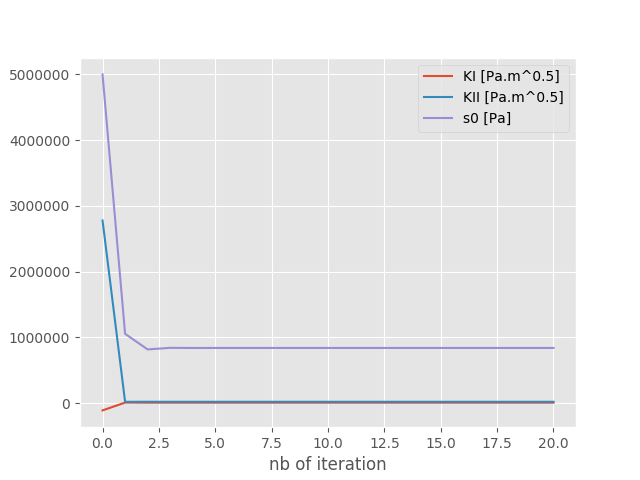

In [24]:
##Display and print final results of KI, KII and s0
print('Sox = ', Soxi)
print('KI = ', KIi)
print('KII = ', KIIi)


f3=plt.figure(3)
ax31=f3.add_subplot(111)
ax31.plot(KI_all)
ax31.plot(KII_all)
ax31.plot(s0_all)
ax31.legend(['KI [Pa.m^0.5]','KII [Pa.m^0.5]','s0 [Pa]'])
ax31.set_xlabel('nb of iteration')
f3.savefig('f3_converg.pdf')

<IPython.core.display.Javascript object>


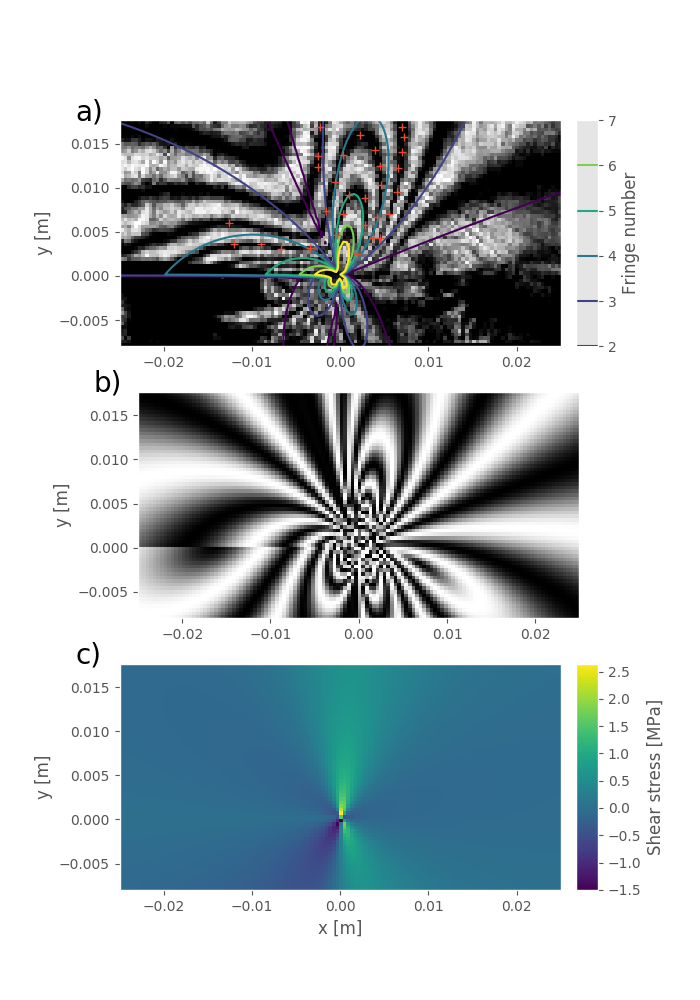

In [56]:
# KIi=10426.8206645; KIIi=49603.6506015; Soxi=1197130.17679

f4=plt.figure(4,figsize=(7,10))
ax41=f4.add_subplot(311)
ax41.pcolor(X,Y,im,cmap='gray')
contours=ax41.contour(X,Y,N_frg(X,Y,v,cs,cd,KIi,KIIi,Soxi,h,fs),levels=[2,3,4,5,6,7])
ax41.set_aspect('equal')

# for i, xpi in enumerate(xp):
#     ax41.annotate(i, (xpi,yp[i]))
ax41.plot(xp,yp,'+')  
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax41.set_aspect('equal');#ax66.set_title('stress')
# stressmap.set_clim([0,40])
divider = make_axes_locatable(ax41)
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(contours, cax=cax,label='Fringe number')
# ax41.set_xlabel('x [m]')
ax41.set_xlim([-0.025,0.025])
ax41.set_ylabel('y [m]')
# f4.tight_layout

We can then simulate the fringes using the inverted parameters:

In [57]:
# f4.savefig('f41_fringenb.pdf')
ax51=f4.add_subplot(312)
ax51.pcolor(X,Y,np.sin(N_frg(X,Y,v,cs,cd,KIi,KIIi,Soxi,h,fs) * np.pi)**2, cmap='gray')
ax51.set_aspect('equal')
ax51.set_xlim([-0.025,0.025])
# ax51.set_xlabel('x [m]')
ax51.set_ylabel('y [m]')
# f5.savefig('f5_syntheticfringes.pdf')

or the shear stress for instance:

In [58]:
# f6=plt.figure(6,figsize=(7,3))
ax61=f4.add_subplot(313)
stress=ax61.pcolor(X,Y,-SS12_mixed(X,Y,v,cs,cd,KIi,KIIi)/1e6)
ax61.set_aspect('equal')
ax61.set_xlabel('x [m]')
ax61.set_ylabel('y [m]')
ax61.set_xlim([-0.025,0.025])
# ax61.set_ylim([-0.025,0.025])
divider = make_axes_locatable(ax61)
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(stress, cax=cax,label='Shear stress [MPa]')

axs=[ax41,ax51,ax61]
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.0, string.ascii_lowercase[n] + ')', transform=ax.transAxes, size=20)#, weight='bold')\n",
# f4.tight_layout()
f4.savefig('f4_all.pdf')

In [59]:
##save png pics
f4.savefig('f4_all.png')
f1.savefig('fig1_picks.png')